# **1. Perkenalan Dataset**

Dataset **tanpa label** dengan penjelasan sebagai berikut:

- Dataset dari **wowevan/dataset-kesejahteraan-pekerja-indonesia**
- **garisKemiskinan.csv**:  Dataset yang memuat data Garis Kemiskinan per Kapita, dengan pemisahan berdasarkan provinsi, tahun, periode survei, jenis pengeluaran, dan daerah tempat tinggal.
   - (5460 rows x 6 columns) [gk: 48561.0 -> 872843.0]: ['provinsi', 'jenis', 'daerah', 'tahun', 'periode', 'gk']
- **minUpah.csv**: Dataset yang mencatat data tentang Upah Minimum Provinsi (UMP), yang terdistribusi berdasarkan provinsi dan tahun.
   - (735 rows x 3 columns) [ump: 245000.0 -> 4641854.0]: ['provinsi', 'tahun', 'ump'] 
- **pengeluaran.csv**: Dataset yang berisi informasi tentang Rata-Rata Pengeluaran per Kapita, dengan pembagian berdasarkan provinsi, tahun, jenis pengeluaran, dan daerah tempat tinggal.
   - (4620 rows x 5 columns) [peng: 59216.0 -> 2525347.0]: ['provinsi', 'daerah', 'jenis', 'tahun', 'peng'] 
- **rataRataUpah.csv**: Dataset yang memuat informasi tentang Rata-Rata Upah Pekerja per Jam, dengan pembagian berdasarkan provinsi dan tahun.
   - (280 rows x 3 columns) [upah: 8525 -> 32685]: ['provinsi', 'tahun', 'upah']



## Target & Plan
- Silhoutte Score > 0.7, fitur => 4 (numerik, kategori). Dataset > 1500
- Akan dilakukan integrasi data sehingga seleksi fitur maksimum adalah 5 Kategori ['provinsi', 'jenis', 'daerah', 'tahun', 'periode'] dan 4 numerik ['gk', 'ump', 'peng', 'upah']

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [14]:
import kagglehub # API Kaggle untuk akses dataset
import pandas as pd
import os # Periksa file dataset

import seaborn as sns # eksplorasi visualisasi
import matplotlib.pyplot as plt # eksplorasi visualisasi

# Preprocessing
import numpy as np
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler # Preprocessing
from sklearn.utils import shuffle
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift # Model
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist

from sklearn.metrics import silhouette_score # Evaluasi Model [target > 0.7 dengan min 5 fitur (numerik, kategori)]
from yellowbrick.cluster import KElbowVisualizer

import scipy.stats as stats # Evaluasi Cluster Provinsi

# Feature Selection
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE # Gunakan RFE untuk Memilih Fitur Terbaik
from sklearn.tree import DecisionTreeClassifier # memilih fitur yang paling berpengaruh
from sklearn.ensemble import RandomForestClassifier # Cek Feature Importance dari Random Forest

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [15]:
# Download latest version
path = kagglehub.dataset_download("wowevan/dataset-kesejahteraan-pekerja-indonesia")
print("Files in dataset:", os.listdir(path))

Files in dataset: ['garisKemiskinan.csv', 'minUpah.csv', 'pengeluaran.csv', 'rataRataUpah.csv']


In [16]:
# Files in dataset: ['garisKemiskinan.csv', 'minUpah.csv', 'pengeluaran.csv', 'rataRataUpah.csv']
df_gk = pd.read_csv(os.path.join(path, 'garisKemiskinan.csv'))
df_ump = pd.read_csv(os.path.join(path, 'minUpah.csv'))
df_peng = pd.read_csv(os.path.join(path, 'pengeluaran.csv'))
df_avg = pd.read_csv(os.path.join(path, 'rataRataUpah.csv'))

In [5]:
# display('First 5 samples:',df_avg.head())
# display('Last 5 samples:',df_avg.tail())

In [6]:
#Dimentions of the dataset
# print('The number of rows are ',df_gk.shape[0],'\n''The number of columns (variables) are',df_gk.shape[1])

In [7]:
# plt.figure(figsize=(8,6))
# sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Matrix")
# plt.show()

# **4. Exploratory Data Analysis (EDA)**
1. **Memahami Struktur Data** (Jumlah baris dan kolom, Jenis data (numerikal atau kategorikal))
2. **Menangani Data yang Hilang**  (Pengisian atau penghapusan)
3. **Analisis Distribusi dan Korelasi** (Analisis Distribusi (statistika deskripfit, histogram, boxplot), hubungan variabel (matriks korelasi atau scatter plot))
4. **Visualisasi Data** (grafik distribusi & diagram batang untuk variabel kategorikal, Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel)

In [17]:
# List DataFrame beserta namanya
dfs = [("Garis Kemiskinan", df_gk), 
       ("Upah per Jam", df_avg), 
       ("UMP", df_ump), 
       ("Pengeluaran", df_peng)]

print("##-- 4.1. STRUKTUR DATA --")
for df_name, df in dfs:
  print(f"{df_name}: {df.shape[0]} rows x {df.shape[1]} columns")
  column_info = ", ".join(f"{col} ({dtype})" for col, dtype in zip(df.columns, df.dtypes))
  print(f"Columns: {column_info}")
  print(df.head())
  print(f"{df.columns[-1]}: min {df.iloc[:,-1].min()} -> max {df.iloc[:,-1].max()}\n")
  
print("##-- 4.2. MISSING VALUE --")
# Looping untuk mengecek missing values hanya pada kolom yang memiliki null
for name, df in dfs:
    missing = df.isnull().sum()
    missing = missing[missing > 0]  # Hanya ambil kolom dengan nilai null > 0
    if not missing.empty:  # Cek jika ada kolom yang memiliki null
        print(f"Missing values in {name}:\n{missing}\n")

##-- 4.1. STRUKTUR DATA --
Garis Kemiskinan: 5460 rows x 6 columns
Columns: provinsi (object), jenis (object), daerah (object), tahun (int64), periode (object), gk (float64)
  provinsi    jenis     daerah  tahun    periode        gk
0     ACEH  MAKANAN  PERKOTAAN   2015      MARET  293697.0
1     ACEH  MAKANAN  PERKOTAAN   2015  SEPTEMBER  302128.0
2     ACEH  MAKANAN  PERKOTAAN   2016      MARET  306243.0
3     ACEH  MAKANAN  PERKOTAAN   2016  SEPTEMBER  319768.0
4     ACEH  MAKANAN  PERDESAAN   2015      MARET  297479.0
gk: min 48561.0 -> max 872843.0

Upah per Jam: 280 rows x 3 columns
Columns: provinsi (object), tahun (int64), upah (int64)
  provinsi  tahun   upah
0     ACEH   2015  11226
1     ACEH   2016  13627
2     ACEH   2017  14809
3     ACEH   2018  13814
4     ACEH   2019  15065
upah: min 8525 -> max 32685

UMP: 735 rows x 3 columns
Columns: provinsi (object), tahun (int64), ump (float64)
  provinsi  tahun       ump
0     ACEH   2002  330000.0
1     ACEH   2003  425000.0
2 

- 🌟 Missing Value: gk, ump, peng
- 🌟 Tahun ubah menjadi string

In [18]:
# Cek Duplikat dan outliers
for name, df in dfs:
    print(f"Duplicate values in {name}: {df.duplicated().sum()}")

Duplicate values in Garis Kemiskinan: 0
Duplicate values in Upah per Jam: 0
Duplicate values in UMP: 0
Duplicate values in Pengeluaran: 0


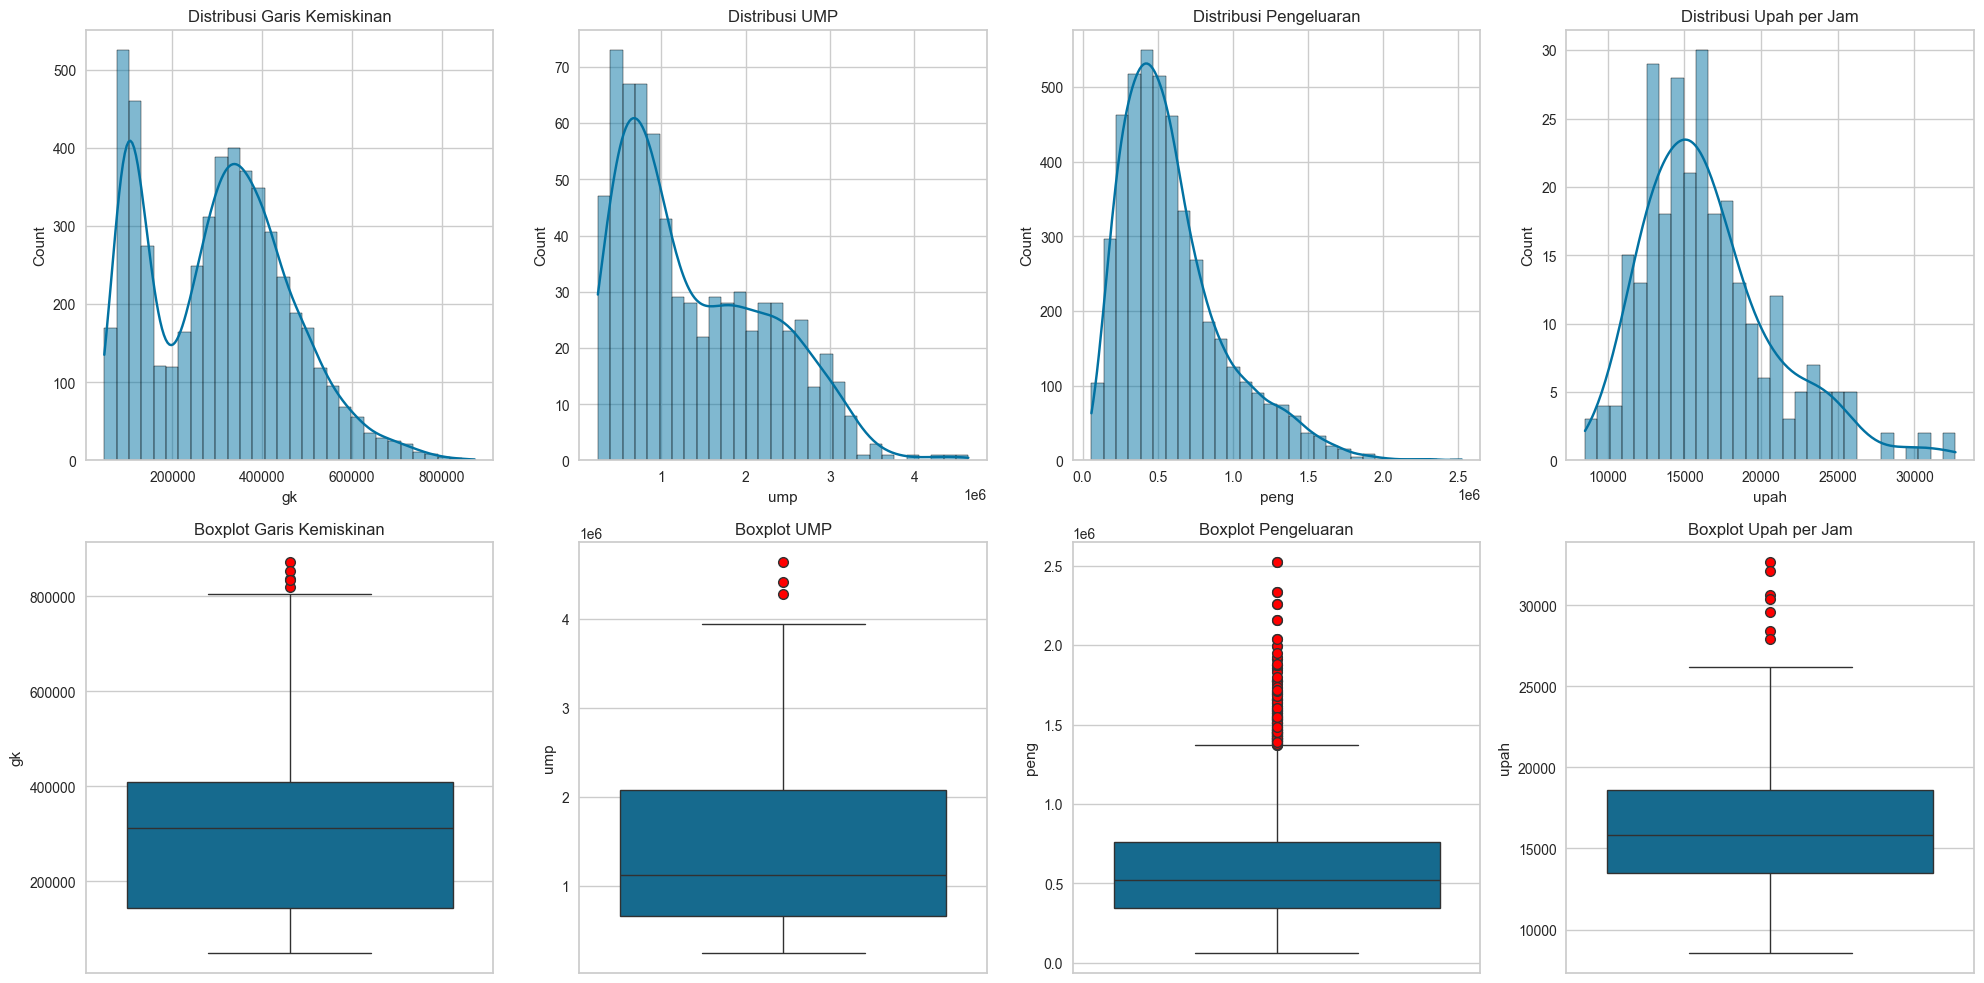

In [19]:
##-- 4.3. DISTRIBUSI & KORELASI --
# Buat figure dan axis dengan 2 baris & 4 kolom
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Data numberic yang di plot, normalisasi & cleaning
dict_nums = {
    "Garis Kemiskinan": df_gk["gk"],
    "UMP": df_ump["ump"],
    "Pengeluaran": df_peng["peng"],
    "Upah per Jam": df_avg["upah"]
}

# Looping untuk membuat histogram (Distribusi) di baris pertama & boxplot (Outliers) di baris kedua
for i, (label, data) in enumerate(dict_nums.items()):
    # Baris 1: Histogram (Distribusi Data)
    sns.histplot(data, bins=30, kde=True, ax=axes[0, i])
    axes[0, i].set_title(f"Distribusi {label}")

    # Baris 2: Boxplot (Outliers)
    sns.boxplot(data=data, orient="v", ax=axes[1, i], flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 7})
    axes[1, i].set_title(f"Boxplot {label}")

# Atur tata letak agar tidak bertumpuk
plt.tight_layout()
plt.show()

🌟 Perlu Data Cleaning (Outliers) dan Normalisasi

In [12]:
# # singgle visual
# # Buat figure dan axis dengan 4 kolom
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# # List nama kolom yang ingin dipplot
# num_cols = {'Garis Kemiskinan': df_gk['gk'], 'UMP': df_ump['ump'], 'Pengeluaran': df_peng['peng'], 'Rata-RataUpah per Jam': df_avg['upah']}

# # Looping untuk membuat histogram tiap kolom
# for i, (label, data) in enumerate(num_cols.items()):
#     sns.histplot(data, bins=30, kde=True, ax=axes[i])
#     axes[i].set_title(f"Distribusi {label}")

# # Tampilkan plot
# plt.tight_layout()
# plt.show()

In [13]:
# # Outliers (not used for now)
# fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# # Data yang akan diplot
# data_dict = {
#     "Garis Kemiskinan": df_gk["gk"],
#     "UMP": df_ump["ump"],
#     "Pengeluaran": df_peng["peng"],
#     "Upah per Jam": df_avg["upah"]
# }

# # Looping untuk membuat boxplot
# for i, (label, data) in enumerate(data_dict.items()):
#     sns.boxplot(data=data, orient="v", ax=axes[i], flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 7})
#     axes[i].set_title(f"Boxplot {label}")

# # Tampilkan plot
# plt.tight_layout()
# plt.show()

# **5. Data Preprocessing**

1. Menghapus atau Menangani Data Kosong (Missing Values) ✅
2. Menghapus Data Duplikat (tidak ada duplikasi data)
3. Deteksi dan Penanganan Outlier ✅
4. Data Integration ✅ (gabungkan berbagai fitur jadi satu data)
5. Normalisasi atau Standarisasi Fitur ✅ (memperbaiki distribusi)
6. Encoding Data Kategorikal ✅(dilakukan setelah df digabung, jadi tidak perlu satu")
7. Binning (Pengelompokan Data) ❌ Tidak ada data ordinal yang bisa di binning kan

Dalam clustering, setiap data harus memiliki nilai numerik yang lengkap karena algoritma clustering seperti K-Means, Hierarchical Clustering, dan DBSCAN tidak bisa menangani missing values secara langsung. 

In [20]:
## -- 5.1 Data Cleaning: Missing Value

for label, data in dict_nums.items():
    missing_before = data.isnull().sum()
    if missing_before > 0:  # Hanya tampilkan jika ada missing values
        print(f"Missing values in {label}: {missing_before}")
        
    # Isi missing values dengan mean
    data.fillna(data.mean(), inplace=True)
        # if not missing.empty:  # Cek jika ada kolom yang memiliki null

# Cek apakah masih ada missing values setelah pengisian
missing_after = {label: data.isnull().sum() for label, data in dict_nums.items() if data.isnull().sum() > 0}

if missing_after:
    print("\nMissing values after filling:", missing_after)
else:
    print("\nAll missing values have been filled.")

Missing values in Garis Kemiskinan: 199
Missing values in UMP: 24
Missing values in Pengeluaran: 108

All missing values have been filled.


Kolom: gk=5460, upah=280, ump=735, peng=4620
Outliers in Garis Kemiskinan (gk): 9 [ New Shape: (5451, 6) ]
Outliers in Upah per Jam (upah): 7 [ New Shape: (273, 3) ]
Outliers in UMP (ump): 3 [ New Shape: (732, 3) ]
Outliers in Pengeluaran (peng): 210 [ New Shape: (4410, 5) ]
List label `cleaned_dfs`: ['Garis Kemiskinan', 'Upah per Jam', 'UMP', 'Pengeluaran']
Garis Kemiskinan: 5451
Upah per Jam: 273
UMP: 732
Pengeluaran: 4410


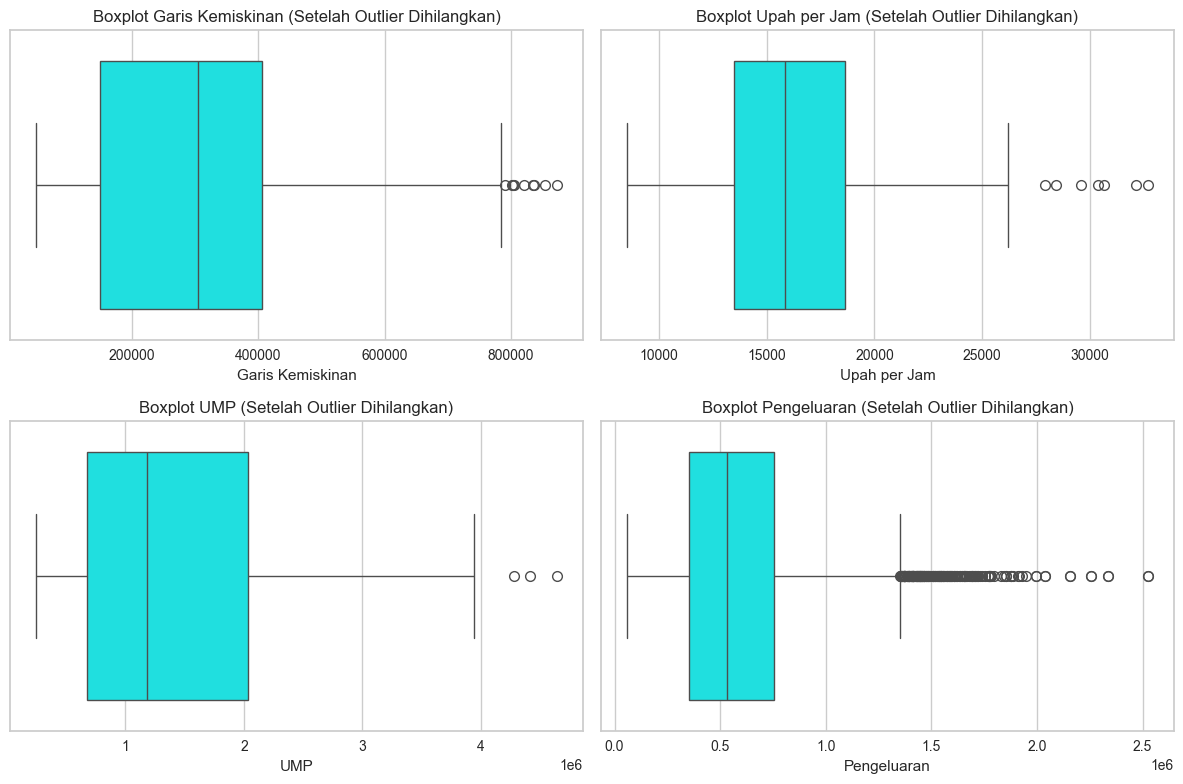

In [32]:
## -- 5.4 Data Cleaning: Outliers
 
# Dictionary untuk menyimpan hasil data tanpa outlier
cleaned_dfs = {}

# Menampilkan boxplot hasil pembersihan outliers
plt.figure(figsize=(12, 8))

# Tampilkan Jumlah Lama
print(f"Kolom: gk={df_gk.shape[0]}, upah={df_avg.shape[0]}, ump={df_ump.shape[0]}, peng={df_peng.shape[0]}")
 
for i, (name, df) in enumerate(dfs, 1):  # Tambahkan enumerate untuk indeks subplot
    last_col = df.columns[-1]  # Ambil kolom terakhir dari dataset
    q1, q3 = df[last_col].quantile([0.25, 0.75])
    iqr = q3 - q1  
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    # Hanya membersihkan outliers pada kolom terakhir
    df_clean = df[(df[last_col] >= lower_bound) & (df[last_col] <= upper_bound)]
    cleaned_dfs[name] = df_clean  # Simpan hasil pembersihan
    
    # Identifikasi outliers
    outliers = df[(df[last_col] < lower_bound) | (df[last_col] > upper_bound)]
    print(f"Outliers in {name} ({last_col}): {outliers.shape[0]} [ New Shape: {df_clean.shape} ]")
    
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[last_col], color='cyan')
    plt.title(f"Boxplot {name} (Setelah Outlier Dihilangkan)")
    plt.xlabel(name)

# Menampilkan kolom list baru
print("List label `cleaned_dfs`:", list(cleaned_dfs.keys()))
# Menampilkan list hasil pembersihan
for key in list(cleaned_dfs.keys()):
    print(f"{key}: {cleaned_dfs[key].shape[0]}")

plt.tight_layout()
plt.show()

In [ ]:
## Second Outlier Handler
# merged_data.info()

In [76]:
### Data Integration (Proses Utama sebelum cleaning, normalisasi, standarisasi, & transformasi)
# List label `cleaned_dfs`: ['Garis Kemiskinan', 'Upah per Jam', 'UMP', 'Pengeluaran']
merged_data = cleaned_dfs['Garis Kemiskinan'].merge(cleaned_dfs['Pengeluaran'], on=['provinsi', 'jenis', 'daerah', 'tahun']).merge(cleaned_dfs['UMP'], on=['provinsi', 'tahun']).merge(cleaned_dfs['Upah per Jam'], on=['provinsi', 'tahun'])
display(merged_data.head(20))
display(merged_data.shape) # shape (4531, 10)

,provinsi,jenis,daerah,tahun,periode,gk,peng,ump,upah
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,466355.0,1900000.0,11226
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,466355.0,1900000.0,11226
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0,548853.0,2118500.0,13627
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0,548853.0,2118500.0,13627
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,395136.0,1900000.0,11226
5,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,306737.0,395136.0,1900000.0,11226
6,ACEH,MAKANAN,PERDESAAN,2016,MARET,315697.0,412251.0,2118500.0,13627
7,ACEH,MAKANAN,PERDESAAN,2016,SEPTEMBER,324854.0,412251.0,2118500.0,13627
8,ACEH,MAKANAN,PERDESAANPERKOTAAN,2015,MARET,296406.0,415354.0,1900000.0,11226
9,ACEH,MAKANAN,PERDESAANPERKOTAAN,2015,SEPTEMBER,305428.0,415354.0,1900000.0,11226


(4531, 9)

In [37]:
# Data Cleaning: Provinsi INDONESIA (btw, tidak ada null value)
merged_data = merged_data[merged_data['provinsi'] != 'INDONESIA'] # 4531 -> 4395

# Data transformation: type tahun number to string
merged_data['tahun'] = merged_data['tahun'].astype(str)
# merged_data.info()

## TRANSFORMING

In [108]:
# TRANSFORMASI AGREGAT (DATA AGGREGATION)
# Menyederhanakan Dataset Menjadi Bentuk yang lebih solid
# merged_data.head(20)
# Misalkan 'merged_data' adalah DataFrame yang kamu gunakan
agg_df = merged_data.groupby(['provinsi', 'jenis', 'daerah', 'tahun'], as_index=False).agg({
    'gk': 'mean',      # Bisa diganti dengan 'mean', 'max', dll.
    'peng': 'mean',
    'ump': 'mean',   # Jika nilai ump tidak berubah dalam satu grup
    'upah': 'mean'    # Misalnya mengambil rata-rata upah
})
agg_df[['gk', 'peng', 'ump', 'upah']] = agg_df[['gk', 'peng', 'ump', 'upah']].round(0)
print(agg_df.shape)
display(agg_df.head(20))

(2266, 8)


,provinsi,jenis,daerah,tahun,gk,peng,ump,upah
0,ACEH,MAKANAN,PERDESAAN,2015,302108.0,395136.0,1900000.0,11226.0
1,ACEH,MAKANAN,PERDESAAN,2016,320276.0,412251.0,2118500.0,13627.0
2,ACEH,MAKANAN,PERDESAAN,2017,338668.0,494150.0,2500000.0,14809.0
3,ACEH,MAKANAN,PERDESAAN,2018,358189.0,506656.0,2700000.0,13814.0
4,ACEH,MAKANAN,PERDESAAN,2019,379996.0,520759.0,2916810.0,15065.0
5,ACEH,MAKANAN,PERDESAAN,2020,397216.0,566947.0,3165031.0,18099.0
6,ACEH,MAKANAN,PERDESAAN,2021,410828.0,597940.0,3165031.0,17037.0
7,ACEH,MAKANAN,PERDESAAN,2022,448121.0,633566.0,3166460.0,16772.0
8,ACEH,MAKANAN,PERDESAANPERKOTAAN,2015,300917.0,415354.0,1900000.0,11226.0
9,ACEH,MAKANAN,PERDESAANPERKOTAAN,2016,318174.0,451952.0,2118500.0,13627.0


In [109]:
# agg_df.head(20)

In [110]:
agg_df2 = agg_df.groupby(['provinsi', 'tahun', 'daerah'], as_index=False).agg({
    'gk': 'mean',      # Bisa diganti dengan 'mean', 'max', dll.
    'peng': 'mean',
    'ump': 'mean',   # Jika nilai ump tidak berubah dalam satu grup
    'upah': 'mean'    # Misalnya mengambil rata-rata upah
})
agg_df2[['gk', 'peng', 'ump', 'upah']] = agg_df2[['gk', 'peng', 'ump', 'upah']].round(0)
print(agg_df2.shape)
display(agg_df2.head(20))

(816, 7)


,provinsi,tahun,daerah,gk,peng,ump,upah
0,ACEH,2015,PERDESAAN,258845.0,436879.0,1900000.0,11226.0
1,ACEH,2015,PERDESAANPERKOTAAN,263974.0,501412.0,1900000.0,11226.0
2,ACEH,2015,PERKOTAAN,276912.0,664200.0,1900000.0,11226.0
3,ACEH,2016,PERDESAAN,273271.0,456720.0,2118500.0,13627.0
4,ACEH,2016,PERDESAANPERKOTAAN,278573.0,538729.0,2118500.0,13627.0
5,ACEH,2016,PERKOTAAN,291153.0,738897.0,2118500.0,13627.0
6,ACEH,2017,PERDESAAN,289533.0,520770.0,2500000.0,14809.0
7,ACEH,2017,PERDESAANPERKOTAAN,296526.0,601996.0,2500000.0,14809.0
8,ACEH,2017,PERKOTAAN,312628.0,791244.0,2500000.0,14809.0
9,ACEH,2018,PERDESAAN,307327.0,558603.0,2700000.0,13814.0


### 2nd EDA after Dataset Agregat

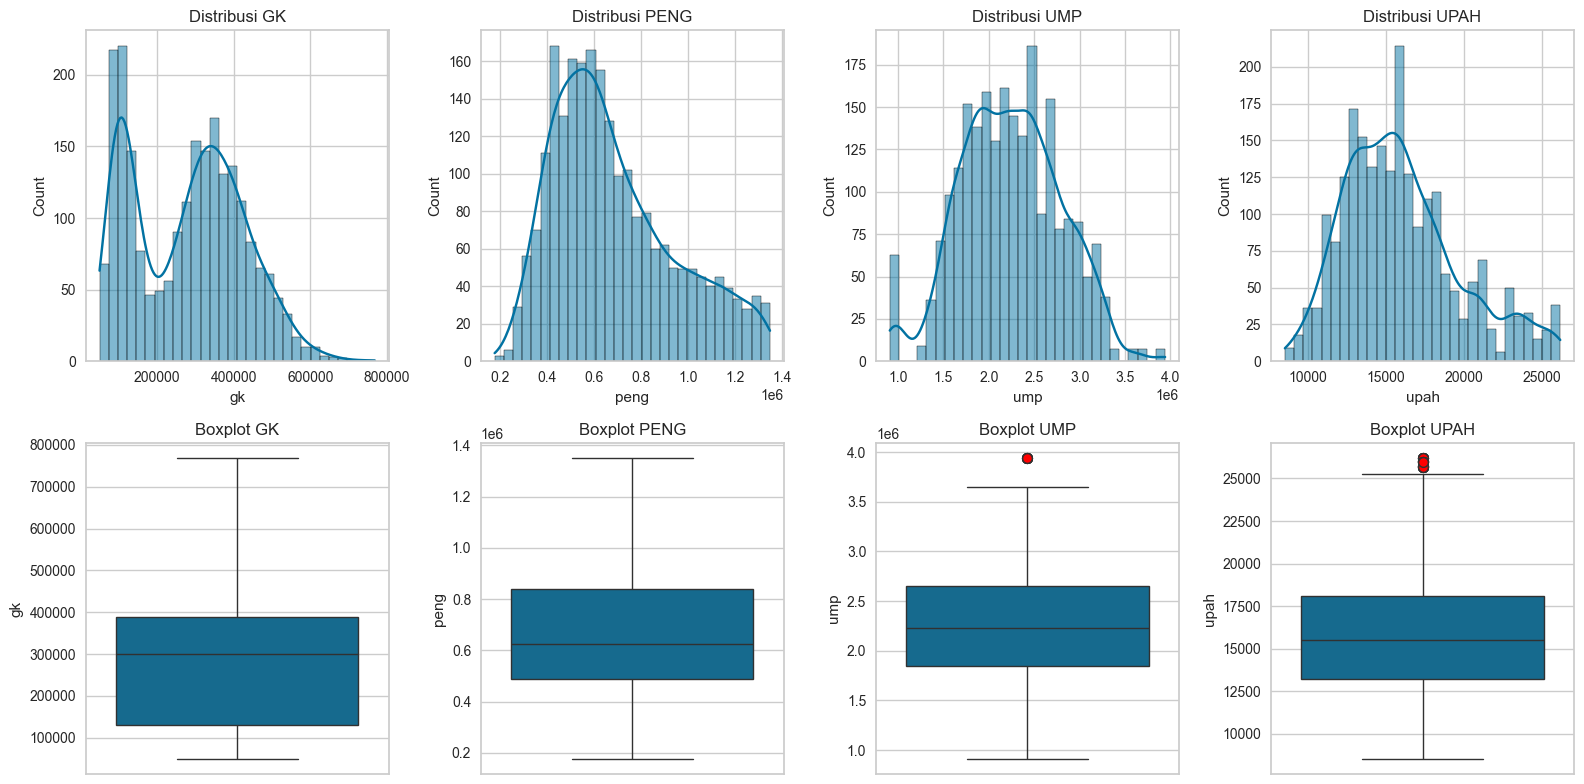

In [111]:
# Periksa Distribusi dan Outlier
# Pastikan data sudah dalam format DataFrame
# Misalnya, kita memilih beberapa kolom numerik untuk visualisasi
numerical_cols = ["gk", "peng", "ump", "upah"]

# Membuat subplot untuk setiap kolom numerik
fig, axes = plt.subplots(2, len(numerical_cols), figsize=(16, 8))

for i, col in enumerate(numerical_cols):
    data = agg_df[col]  # Mengambil kolom data
    label = col.upper()  # Label untuk judul

    # Histogram (Distribusi Data)
    sns.histplot(data, bins=30, kde=True, ax=axes[0, i])
    axes[0, i].set_title(f"Distribusi {label}")

    # Boxplot (Outliers)
    sns.boxplot(y=data, ax=axes[1, i], flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 7})
    axes[1, i].set_title(f"Boxplot {label}")

# Menampilkan plot
plt.tight_layout()
plt.show()

### Cleaning Outlier (agg_df -> merged_data_clean) 

In [112]:
# Menyimpan outliers dalam dictionary
outliers_dict = {}
print(agg_df.shape)
for col in numerical_cols:
    Q1 = agg_df[col].quantile(0.25)  # Kuartil 1
    Q3 = agg_df[col].quantile(0.75)  # Kuartil 3
    IQR = Q3 - Q1  # Rentang interkuartil
    
    # Menentukan batas bawah dan atas
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers
    outliers = agg_df[(agg_df[col] < lower_bound) | (agg_df[col] > upper_bound)]
    
    # Show Before
    outliers_dict[col] = outliers

    print(f"Outliers in {col} (before cleaning): {outliers.shape[0]} data points")
    
    # Menghapus outliers dari ump dan upah
    merged_data_clean = agg_df[~agg_df.index.isin(outliers_dict[col].index)]
    
    # Filter 2nd outliers
    outliers = merged_data_clean[(merged_data_clean[col] < lower_bound) | (merged_data_clean[col] > upper_bound)]
    
    # Show After
    print(f"Outliers in {col} (after cleaning): {outliers.shape[0]} data points\n")
print(merged_data_clean.shape)

(2266, 8)
Outliers in gk (before cleaning): 0 data points
Outliers in gk (after cleaning): 0 data points

Outliers in peng (before cleaning): 0 data points
Outliers in peng (after cleaning): 0 data points

Outliers in ump (before cleaning): 7 data points
Outliers in ump (after cleaning): 0 data points

Outliers in upah (before cleaning): 38 data points
Outliers in upah (after cleaning): 0 data points

(2228, 8)


### EDA Df Aggregat

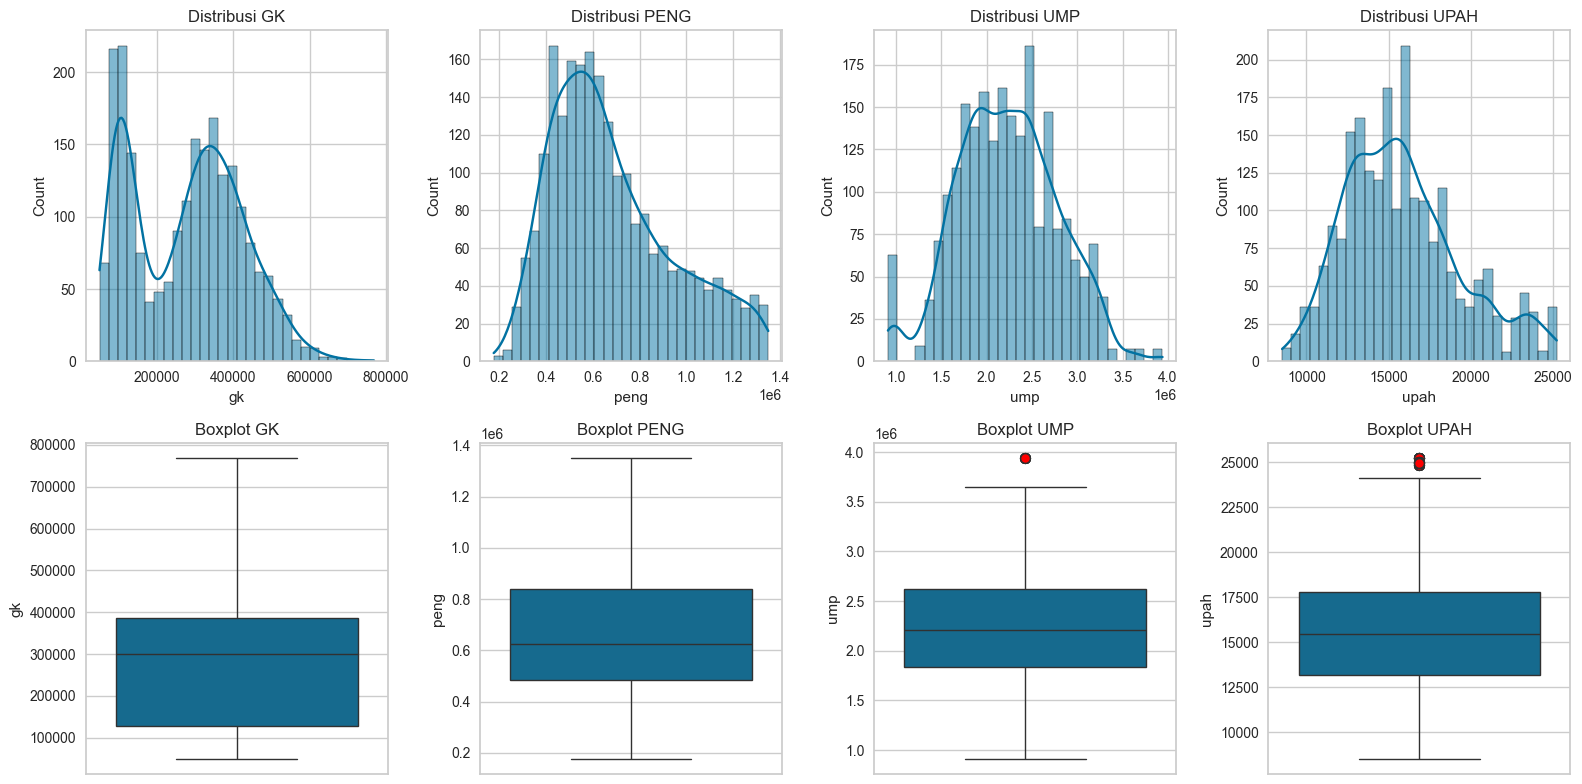

In [113]:
# Membuat subplot untuk setiap kolom numerik
fig, axes = plt.subplots(2, len(numerical_cols), figsize=(16, 8))

for i, col in enumerate(numerical_cols):
    data = merged_data_clean[col]  # Mengambil kolom data
    label = col.upper()  # Label untuk judul

    # Histogram (Distribusi Data)
    sns.histplot(data, bins=30, kde=True, ax=axes[0, i])
    axes[0, i].set_title(f"Distribusi {label}")

    # Boxplot (Outliers)
    sns.boxplot(y=data, ax=axes[1, i], flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 7})
    axes[1, i].set_title(f"Boxplot {label}")

# Menampilkan plot
plt.tight_layout()
plt.show()

In [114]:
# merged_data_clean.head(20)

### Normalization Distribution (merged_data_clean -> df_normal)

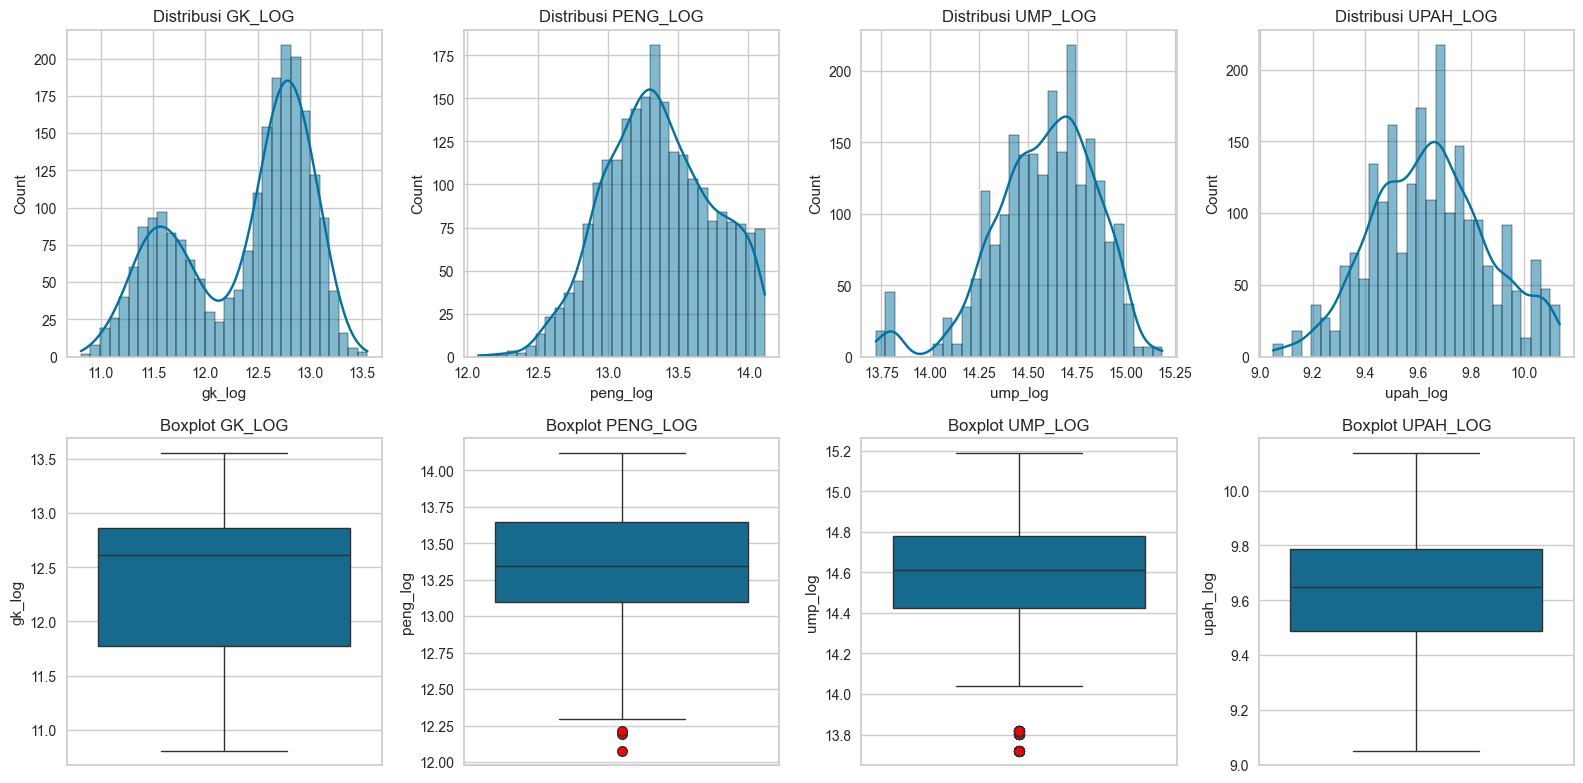

In [120]:
# Normalisasi data (karena distribusi sangat skewed)
# Transformasi Logaritmik (Bagus untuk Right-Skewed Data): log1p untuk menghindari log(0)
df_normal = merged_data_clean.copy()

# Terapkan log transform langsung ke kolom yang diinginkan
for col in ["gk", "peng", "ump", "upah"]:
    df_normal[col] = np.log1p(df_normal[col])

# Ubah nama kolom
df_normal.rename(columns={"gk": "gk_log", "peng": "peng_log", "ump": "ump_log", "upah": "upah_log"}, inplace=True)

num_log_cols = ["gk_log", "peng_log", "ump_log", "upah_log"]

# Membuat subplot untuk setiap kolom numerik
fig, axes = plt.subplots(2, len(num_log_cols), figsize=(16, 8))

for i, col in enumerate(num_log_cols):
    data = df_normal[col]  # Mengambil kolom data
    label = col.upper()  # Label untuk judul

    # Histogram (Distribusi Data)
    sns.histplot(data, bins=30, kde=True, ax=axes[0, i])
    axes[0, i].set_title(f"Distribusi {label}")

    # Boxplot (Outliers)
    sns.boxplot(y=data, ax=axes[1, i], flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 7})
    axes[1, i].set_title(f"Boxplot {label}")

# Menampilkan plot
plt.tight_layout()
plt.show()

### Periksa Kembali Outlier (For Final Cleaning) (df_normal -> df_normal2)

In [125]:
# Menyimpan outliers dalam dictionary
outliers_dict = {}
print(df_normal.shape)
for col in num_log_cols:
    Q1 = df_normal[col].quantile(0.25)  # Kuartil 1
    Q3 = df_normal[col].quantile(0.75)  # Kuartil 3
    IQR = Q3 - Q1  # Rentang interkuartil
    
    # Menentukan batas bawah dan atas
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers
    outliers = df_normal[(df_normal[col] < lower_bound) | (df_normal[col] > upper_bound)]
    
    # Show Before
    outliers_dict[col] = outliers

    print(f"Outliers in {col} (before cleaning): {outliers.shape[0]} data points")
    
    # Menghapus outliers dari ump dan upah
    df_normal2 = df_normal[~df_normal.index.isin(outliers_dict[col].index)]
    
    # Filter 2nd outliers
    outliers = df_normal2[(df_normal2[col] < lower_bound) | (df_normal2[col] > upper_bound)]
    
    # Show After
    print(f"Outliers in {col} (after cleaning): {outliers.shape[0]} data points\n")
print(df_normal2.shape)

(2228, 8)
Outliers in gk_log (before cleaning): 0 data points
Outliers in gk_log (after cleaning): 0 data points

Outliers in peng_log (before cleaning): 3 data points
Outliers in peng_log (after cleaning): 0 data points

Outliers in ump_log (before cleaning): 63 data points
Outliers in ump_log (after cleaning): 0 data points

Outliers in upah_log (before cleaning): 0 data points
Outliers in upah_log (after cleaning): 0 data points

(2228, 8)


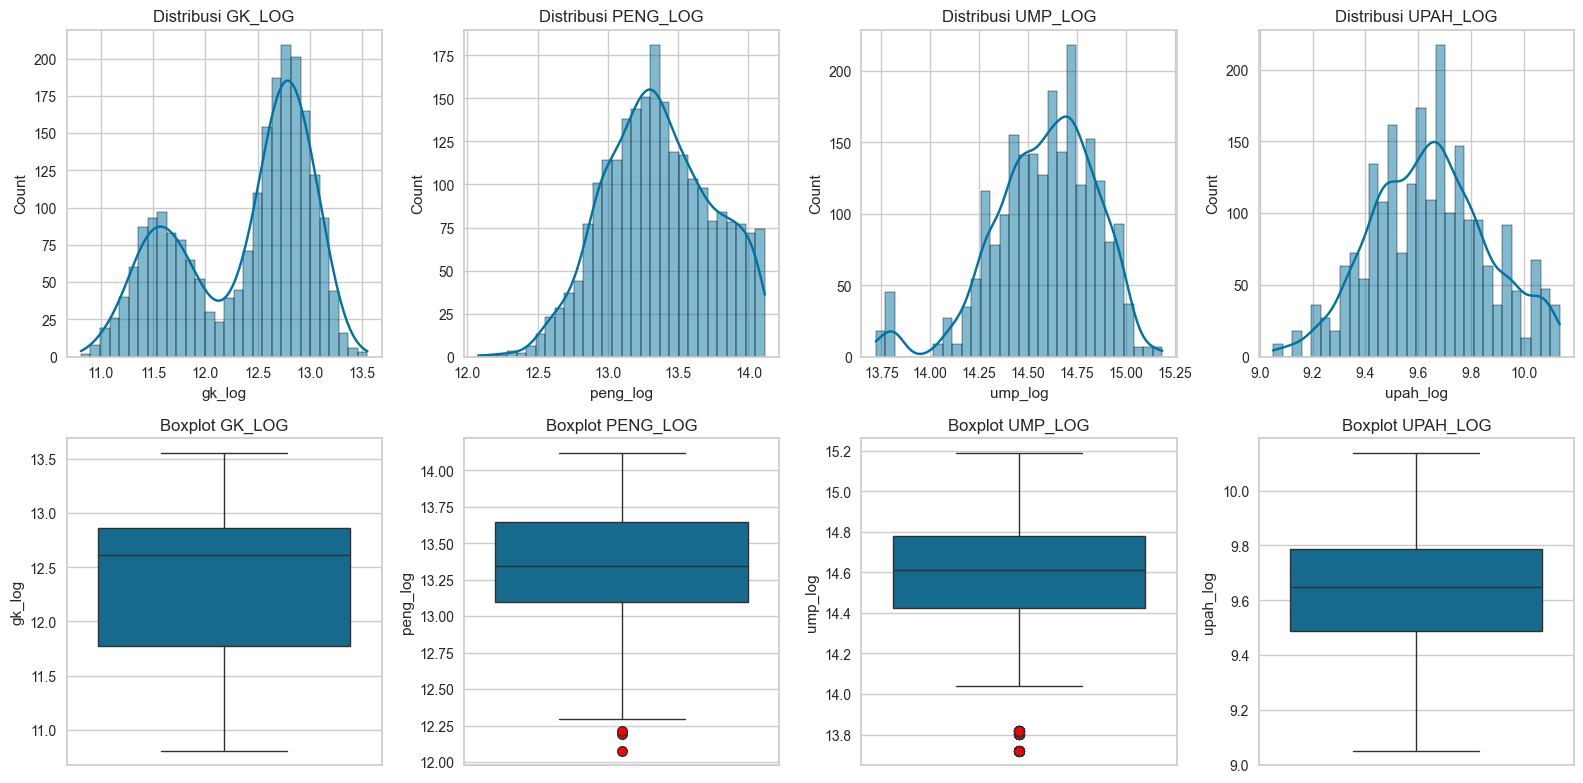

In [133]:
# Membuat subplot untuk setiap kolom numerik
fig, axes = plt.subplots(2, len(num_log_cols), figsize=(16, 8))

for i, col in enumerate(num_log_cols):
    data = df_normal2[col]  # Mengambil kolom data
    label = col.upper()  # Label untuk judul

    # Histogram (Distribusi Data)
    sns.histplot(data, bins=30, kde=True, ax=axes[0, i])
    axes[0, i].set_title(f"Distribusi {label}")

    # Boxplot (Outliers)
    sns.boxplot(y=data, ax=axes[1, i], flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 7})
    axes[1, i].set_title(f"Boxplot {label}")

# Menampilkan plot
plt.tight_layout()
plt.show()

In [134]:
# Menyimpan outliers dalam dictionary
outliers_dict = {}
print(df_normal2.shape)
for col in num_log_cols:
    Q1 = df_normal2[col].quantile(0.25)  # Kuartil 1
    Q3 = df_normal2[col].quantile(0.75)  # Kuartil 3
    IQR = Q3 - Q1  # Rentang interkuartil
    
    # Menentukan batas bawah dan atas
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers
    outliers = df_normal2[(df_normal2[col] < lower_bound) | (df_normal2[col] > upper_bound)]
    
    # Show Before
    outliers_dict[col] = outliers

    print(f"Outliers in {col} (before cleaning): {outliers.shape[0]} data points")
    
    # Menghapus outliers dari ump dan upah
    df_normal3 = df_normal2[~df_normal2.index.isin(outliers_dict[col].index)]
    
    # Filter 2nd outliers
    outliers = df_normal3[(df_normal3[col] < lower_bound) | (df_normal3[col] > upper_bound)]
    
    # Show After
    print(f"Outliers in {col} (after cleaning): {outliers.shape[0]} data points\n")
print(df_normal3.shape)

(2228, 8)
Outliers in gk_log (before cleaning): 0 data points
Outliers in gk_log (after cleaning): 0 data points

Outliers in peng_log (before cleaning): 3 data points
Outliers in peng_log (after cleaning): 0 data points

Outliers in ump_log (before cleaning): 63 data points
Outliers in ump_log (after cleaning): 0 data points

Outliers in upah_log (before cleaning): 0 data points
Outliers in upah_log (after cleaning): 0 data points

(2228, 8)


In [135]:
df_normal3.shape

(2228, 8)

## STANDARITATION ENCODING

In [146]:
### ---- Nurmalisasi / Standarisasi Numerik & Kategori ----
## Ubah tahun menjadi kategori
df_normal3['tahun'] = df_normal3['tahun'].astype(str)

fixed_data = df_normal3.copy()


## Standarisasi / Normalisasi fitur numerik
numeric_cols = df_normal3.select_dtypes(include=['number']).columns

# Gunakan MinMaxScaler agar bisa di-inverse
fixed_data[numeric_cols] = MinMaxScaler().fit_transform(df_normal3[numeric_cols])

## Encoding Kategori
# One Hot Encoding untuk Category
# tahun: ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
# jenis: ['MAKANAN', 'NONMAKANAN', 'TOTAL']
# daerah: ['PERKOTAAN', 'PERDESAAN', 'PERDESAANPERKOTAAN']
# periode: ['MARET', 'SEPTEMBER']
fixed_data = pd.get_dummies(fixed_data, columns=["tahun", "jenis", "daerah"])

# Label Encoding untuk kolom kategori provinsi > 30
label_enc = LabelEncoder()
fixed_data['provinsi_encoded'] = label_enc.fit_transform(fixed_data['provinsi'])

In [147]:
# Tampilan perubahan
display(df_normal3.head())
# display(merged_data['provinsi'].unique())
display(fixed_data.head())

,provinsi,jenis,daerah,tahun,gk_log,peng_log,ump_log,upah_log
0,ACEH,MAKANAN,PERDESAAN,2015,12.618543,12.886988,14.457365,9.326077
1,ACEH,MAKANAN,PERDESAAN,2016,12.676942,12.929390,14.566219,9.519882
2,ACEH,MAKANAN,PERDESAAN,2017,12.732779,13.110596,14.731802,9.603058
3,ACEH,MAKANAN,PERDESAAN,2018,12.788819,13.135590,14.808763,9.533510
4,ACEH,MAKANAN,PERDESAAN,2019,12.847919,13.163045,14.886001,9.620196


,provinsi,gk_log,peng_log,ump_log,upah_log,tahun_2015,tahun_2016,tahun_2017,tahun_2018,tahun_2019,tahun_2020,tahun_2021,tahun_2022,jenis_MAKANAN,jenis_NONMAKANAN,jenis_TOTAL,daerah_PERDESAAN,daerah_PERDESAANPERKOTAAN,daerah_PERKOTAAN,provinsi_encoded
0,ACEH,0.659805,0.396831,0.502248,0.253579,True,False,False,False,False,False,False,False,True,False,False,True,False,False,0
1,ACEH,0.681086,0.417641,0.576514,0.432156,False,True,False,False,False,False,False,False,True,False,False,True,False,False,0
2,ACEH,0.701434,0.506573,0.689483,0.508797,False,False,True,False,False,False,False,False,True,False,False,True,False,False,0
3,ACEH,0.721856,0.518839,0.741989,0.444714,False,False,False,True,False,False,False,False,True,False,False,True,False,False,0
4,ACEH,0.743392,0.532313,0.794686,0.524589,False,False,False,False,True,False,False,False,True,False,False,True,False,False,0


## 1st KMean Test (Before Reduction)

In [148]:
features = fixed_data.select_dtypes(include=['number','boolean']).columns

model_data = fixed_data[features].copy() # untuk menguji model
final_data = fixed_data.copy() # untuk menyimpan perubahan hasil model, jadi fixed_data dan model_data tidak berubah

# model KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(model_data) # sudah di filter
final_data['cluster_kmean'] = labels
silhouette_avg = silhouette_score(model_data, labels)
print(f"Silhouette Score untuk K=3 menggunakan K-Means: {silhouette_avg}")

Silhouette Score untuk K=3 menggunakan K-Means: 0.5336509117031464


## PCA Reduced (5 Fitur)

In [74]:
# Feature Selection
features = fixed_data.select_dtypes(include=['number', 'boolean']).columns
selected_data = fixed_data[features]

# # Data Transformation (sudah dengan minmax)
# scaler = RobustScaler()
# scaled_data = scaler.fit_transform(selected_data)

#Data_Reduction
print(fixed_data.shape)
pca = PCA(n_components=5)
reduced_data = pca.fit_transform(selected_data)
print(reduced_data.shape)

# pca = PCA(n_components=3)  # Coba dengan 2-3 komponen utama
# df_pca = pca.fit_transform(selected_data)

# Lakukan clustering kembali
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(reduced_data)
score = silhouette_score(reduced_data, labels)
print(f"Silhouette Score setelah PCA: {score}")

(2198, 20)
(2198, 5)
Silhouette Score setelah PCA: 0.5515207465953259


In [73]:
print(model_data.shape)
print(reduced_data.shape)

(2198, 19)
(2198, 5)


In [ ]:
# Testing

In [53]:
# pca = PCA(n_components=3)  # Coba dengan 2-3 komponen utama
# df_pca = pca.fit_transform(selected_data)

# # Lakukan clustering kembali
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# labels = kmeans.fit_predict(df_pca)
# score = silhouette_score(df_pca, labels)
# print(f"Silhouette Score setelah PCA: {score}")

## MODELLING AFTER SETUP FIXED DADA

In [ ]:
# coba Membangun Model KMeans dan evaluasi dengan Silhoute method
# Seleksi hanya kolom fitur angka dan boolean (data nominal tidak digunakan)
features = fixed_data.select_dtypes(include=['number']).columns

# model_data = fixed_data[features].copy() # untuk menguji model
# final_data = fixed_data.copy() # untuk menyimpan perubahan hasil model, jadi fixed_data dan model_data tidak berubah

# # model KMeans
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# labels = kmeans.fit_predict(model_data) # sudah di filter
# final_data['cluster_kmean'] = labels
# silhouette_avg = silhouette_score(model_data, labels)
# print(f"Silhouette Score untuk K=3 menggunakan K-Means: {silhouette_avg}")

Index(['gk', 'peng', 'ump', 'upah', 'provinsi_encoded'], dtype='object')

In [ ]:
# model_data.head()

In [ ]:
# Inisialisasi DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Sesuaikan parameter eps dan min_samples
labels_dbscan = dbscan.fit_predict(model_data)

# Tambahkan hasil cluster ke dataset
final_data['cluster_dbscan'] = labels_dbscan

# Filter outlier (-1) sebelum menghitung Silhouette Score
filtered_data = final_data[final_data['cluster_dbscan'] != -1]

# Hitung Silhouette Score jika ada minimal 2 cluster
if len(set(filtered_data['cluster_dbscan'])) > 1:
    silhouette_avg_dbscan = silhouette_score(filtered_data[features], filtered_data['cluster_dbscan'])
    print(f"Silhouette Score untuk DBSCAN: {silhouette_avg_dbscan}")
else:
    print("DBSCAN hanya menghasilkan satu cluster atau banyak outlier, Silhouette Score tidak bisa dihitung.")

Silhouette Score untuk DBSCAN: 0.6125166711748282


In [ ]:
# Inisialisasi Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3)  # Sesuaikan jumlah cluster jika perlu
labels_agglo = agglo.fit_predict(model_data)

# Tambahkan hasil cluster ke dataset
final_data['cluster_agglo'] = labels_agglo

# Hitung Silhouette Score
silhouette_avg_agglo = silhouette_score(model_data, labels_agglo)
print(f"Silhouette Score untuk Agglomerative Clustering: {silhouette_avg_agglo}")

Silhouette Score untuk Agglomerative Clustering: 0.5330970472691702


In [ ]:
mean_shift = MeanShift(bandwidth=0.1)
mean_shift_labels = mean_shift.fit_predict(model_data)

final_data['cluster_ms'] = mean_shift_labels # Simpan hasil cluster
# Hitung Silhouette Score
print(f"Silhouette Score untuk MeanShift Clustering: {silhouette_score(model_data, mean_shift_labels)}")

Silhouette Score untuk MeanShift Clustering: 0.5773333094766795


## EVALUASI

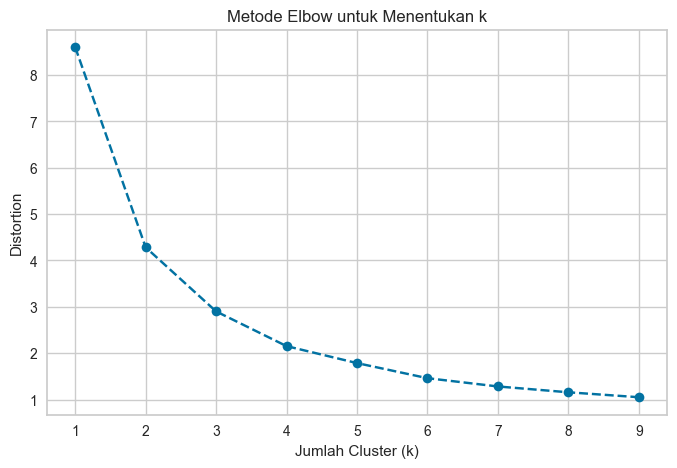

In [ ]:
# Lihat Map Silhoute N Cluster Optimum 
# Mencoba berbagai jumlah cluster
distortions = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(fixed_data[features])
    distortions.append(sum(np.min(cdist(fixed_data[features], kmeans.cluster_centers_, 'euclidean'), axis=1)) / fixed_data[features].shape[0])

# Plot hasil Elbow Method
plt.figure(figsize=(8,5))
plt.plot(K_range, distortions, marker='o', linestyle='--')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Distortion')
plt.title('Metode Elbow untuk Menentukan k')
plt.show()

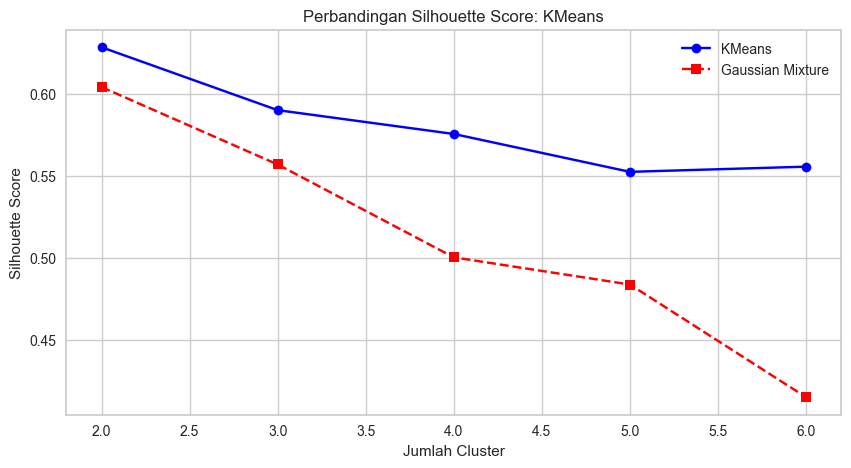

In [ ]:
silhouette_scores_kmeans = []
silhouette_scores_gmm = []
K_range = range(2, 7)  # Minimal 2 cluster

for k in K_range:
    # KMeans Clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_kmeans = kmeans.fit_predict(fixed_data[features])
    score_kmeans = silhouette_score(fixed_data[features], cluster_labels_kmeans)
    silhouette_scores_kmeans.append(score_kmeans)

    # Gaussian Mixture Model (GMM)
    gmm = GaussianMixture(n_components=k, random_state=42)
    cluster_labels_gmm = gmm.fit_predict(fixed_data[features])
    score_gmm = silhouette_score(fixed_data[features], cluster_labels_gmm)
    silhouette_scores_gmm.append(score_gmm)

# Plot Silhouette Score
plt.figure(figsize=(10,5))
plt.plot(K_range, silhouette_scores_kmeans, marker='o', linestyle='-', label="KMeans", color='blue')
plt.plot(K_range, silhouette_scores_gmm, marker='s', linestyle='--', label="Gaussian Mixture", color='red')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Silhouette Score")
plt.title("Perbandingan Silhouette Score: KMeans")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# final_data.head()
print(final_data['cluster_kmean'].unique())
print(final_data['cluster_agglo'].unique())
print(final_data['cluster_dbscan'].unique()) # (terlalu banyak cluster)
# print(final_data['cluster_ms'].unique()) # (terlalu banyak cluster)

[1 0 2]
[0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [ ]:
# final_data.columns
# features
selected_features = list(features) + ['cluster_kmean']

selected_features

['gk', 'peng', 'ump', 'upah', 'provinsi_encoded', 'cluster_kmean']

In [ ]:
eval_data = final_data[selected_features]
X = eval_data.drop(columns=['cluster_kmean'])  # Buang label klaster
y = eval_data['cluster_kmean']  # type: ignore # Gunakan hasil klaster sebagai target

# Gunakan model Decision Tree
model = DecisionTreeClassifier()
selector = RFE(model, n_features_to_select=5)  # Pilih 5 fitur terbaik
selector.fit(X, y)

# Ambil fitur yang terpilih
selected_features = X.columns[selector.support_]
print("Fitur yang dipilih Decission Tree:\n", selected_features)

# Tampilkan Feature Importance dari Random Forest (Embedded Method)
rf = RandomForestClassifier()
rf.fit(X, y)

# Tampilkan ranking fitur
importances = pd.DataFrame({'Fitur': X.columns, 'Importance': rf.feature_importances_})
importances = importances.sort_values(by="Importance", ascending=False)
print("\nRank Fitur berdsarkan Random Forest:\n",importances)

Fitur yang dipilih Decission Tree:
 Index(['gk', 'peng', 'ump', 'upah', 'provinsi_encoded'], dtype='object')

Rank Fitur berdsarkan Random Forest:
               Fitur  Importance
4  provinsi_encoded    0.892970
2               ump    0.054521
3              upah    0.040570
0                gk    0.007788
1              peng    0.004151


## FEATURE SELECTION

In [ ]:
fixed_data.head()

,provinsi,gk,peng,ump,upah,tahun_2015,tahun_2016,tahun_2017,tahun_2018,tahun_2019,...,tahun_2022,jenis_MAKANAN,jenis_NONMAKANAN,jenis_TOTAL,daerah_PERDESAAN,daerah_PERDESAANPERKOTAAN,daerah_PERKOTAAN,periode_MARET,periode_SEPTEMBER,provinsi_encoded
0,ACEH,0.340536,0.248422,0.326628,0.152832,True,False,False,False,False,...,False,True,False,False,False,False,True,True,False,0
1,ACEH,0.352248,0.248422,0.326628,0.152832,True,False,False,False,False,...,False,True,False,False,False,False,True,False,True,0
2,ACEH,0.357965,0.319013,0.398717,0.288689,False,True,False,False,False,...,False,True,False,False,False,False,True,True,False,0
3,ACEH,0.376753,0.319013,0.398717,0.288689,False,True,False,False,False,...,False,True,False,False,False,False,True,False,True,0
4,ACEH,0.345790,0.187483,0.326628,0.152832,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,0


In [ ]:
features = fixed_data.select_dtypes(include=['number', 'boolean']).columns
new_data =  fixed_data.copy()
number_data = fixed_data[features]
selector = VarianceThreshold(threshold=0.1)
df_selected = selector.fit_transform(number_data)

In [ ]:
df_selected[0]

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.])

In [ ]:
# UJI LAGI K-MEANS SETELAH FEATURE SELECTION
# model KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_selected) # sudah di filter
new_data['cluster_kmean'] = labels
print(f"Silhouette Score untuk K=3 menggunakan K-Means: {silhouette_score(df_selected, labels)}")

Silhouette Score untuk K=3 menggunakan K-Means: 0.43076959261533954


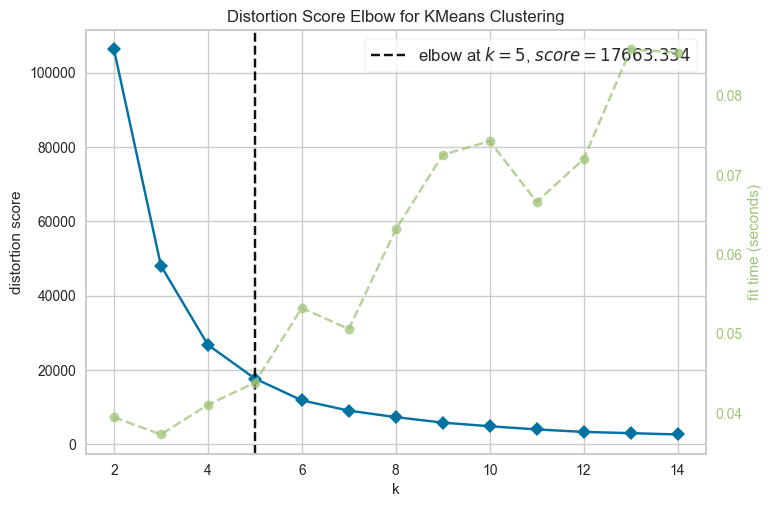

Optimal jumlah cluster: 5


In [ ]:
# Pilih hanya fitur numerik untuk clustering
X = number_data.select_dtypes(include=['number'])

# Inisialisasi model K-Means
kmeans = KMeans(random_state=42, n_init=10)

# Gunakan Elbow Method
visualizer = KElbowVisualizer(kmeans, k=(2, 15))

# Fit model dengan data numerik
visualizer.fit(X)
visualizer.show()

# Simpan jumlah cluster optimal
optimal_k = visualizer.elbow_value_
print(f"Optimal jumlah cluster: {optimal_k}")

In [ ]:
# Hyperparameter Tuning dengan jumlah cluster optimal
kmeans_optimized = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=500, tol=1e-4)

# Fit model dan prediksi klaster
X['Cluster_KMeans_Optimized'] = kmeans_optimized.fit_predict(X)

# Evaluasi ulang dengan Silhouette Score
sil_score_optimized = silhouette_score(X, kmeans_optimized.fit_predict(X))

print(f"Silhouette Score (Optimized K-Means): {sil_score_optimized:.4f}")

Silhouette Score (Optimized K-Means): 0.6017


In [ ]:
X.head()

,gk,peng,ump,upah,provinsi_encoded,Cluster_KMeans_Optimized
0,0.340536,0.248422,0.326628,0.152832,0,0
1,0.352248,0.248422,0.326628,0.152832,0,0
2,0.357965,0.319013,0.398717,0.288689,0,0
3,0.376753,0.319013,0.398717,0.288689,0,0
4,0.345790,0.187483,0.326628,0.152832,0,0


In [ ]:
X

,gk,peng,ump,upah,provinsi_encoded,Cluster_KMeans_Optimized
0,0.340536,0.248422,0.326628,0.152832,0,0
1,0.352248,0.248422,0.326628,0.152832,0,0
2,0.357965,0.319013,0.398717,0.288689,0,0
3,0.376753,0.319013,0.398717,0.288689,0,0
4,0.345790,0.187483,0.326628,0.152832,0,0
...,...,...,...,...,...,...
4390,0.680037,0.730024,0.769027,0.931308,23,4
4391,0.682831,0.888769,0.769027,0.931308,23,4
4392,0.706637,0.888769,0.769027,0.931308,23,4
4393,0.777442,0.943114,0.874944,0.881118,23,4


In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
df_selected = selector.fit_transform(number_data)

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
number_data['Cluster_KMeans_Optimized'] = kmeans.fit_predict(df_selected)

sil_score = silhouette_score(df_selected, number_data['Cluster_KMeans_Optimized'])
print(f'Silhouette Score after Feature Selection: {sil_score:.4f}')

Silhouette Score after Feature Selection: 0.4256


In [ ]:
# print(df_gk.columns)
# print(df_peng.columns)
# print(df_ump.columns)
# print(df_avg.columns)
# Index(['provinsi', 'jenis', 'daerah', 'tahun', 'periode', 'gk'], dtype='object')
# Index(['provinsi', 'daerah', 'jenis', 'tahun', 'peng'], dtype='object')
# Index(['provinsi', 'tahun', 'ump'], dtype='object')
# Index(['provinsi', 'tahun', 'upah'], dtype='object')
# display(merged_data.shape)
# display(merged_data_2.shape)
# display(merged_data.duplicated().sum())
# display(merged_data_2.duplicated().sum())

In [ ]:
# # Feature Selection
# features = ['ump', 'gk', 'upah', 'peng']
# selected_data = merged_data[features]

# # Data Transformation
# scaler = RobustScaler()
# scaled_data = scaler.fit_transform(selected_data)

# #Data_Reduction
# pca = PCA(n_components=4)
# reduced_data = pca.fit_transform(scaled_data)

In [ ]:
# #Feature Selection
# plt.figure(figsize=(8, 5))
# sns.heatmap(selected_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title("Matriks Korelasi antar Fitur", fontsize=16)
# plt.show()

# pca_loadings = pd.DataFrame(
#     pca.components_.T,
#     columns=[f"PC{i+1}" for i in range(pca.n_components_)],
#     index=features
# )

# plt.figure(figsize=(8, 5))
# sns.heatmap(pca_loadings, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
# plt.title("PCA Loading untuk Setiap Fitur", fontsize=16)
# plt.show()
# # Hasil: 

In [ ]:
# #Sample Data
# sample_fraction = 0.3
# sample_data = shuffle(reduced_data, random_state=88)[:int(len(reduced_data) * sample_fraction)]

In [ ]:
# mean_shift = MeanShift(bandwidth=0.1)
# mean_shift_labels = mean_shift.fit_predict(reduced_data)
# merged_data['cluster_ms'] = mean_shift_labels

In [ ]:
# bandwidth_values = np.linspace(0.01, 1, 10)
# mean_shift_scores = []
# for bandwidth in bandwidth_values:
#     mean_shift = MeanShift(bandwidth=bandwidth)
#     labels = mean_shift.fit_predict(sample_data)
#     if len(set(labels)) > 1:
#         score = silhouette_score(sample_data, labels)
#         mean_shift_scores.append(score)
#     else:
#         mean_shift_scores.append(-1)

# plt.figure(figsize=(8, 5))
# plt.plot(bandwidth_values, mean_shift_scores, marker='o', linestyle='--')
# plt.title("Silhouette Scores for Mean Shift")
# plt.xlabel("Bandwidth")
# plt.ylabel("Silhouette Score")
# plt.show()

In [ ]:
## -- 5.3 Normalisasi / Standarisasi Fitur (provinsi, lokasi, periode, tahun)
# print(df_gk.columns)
# print(df_peng.columns)
# print(df_ump.columns)
# print(df_avg.columns)
# Index(['provinsi', 'jenis', 'daerah', 'tahun', 'periode', 'gk'], dtype='object')
# Index(['provinsi', 'daerah', 'jenis', 'tahun', 'peng'], dtype='object')
# Index(['provinsi', 'tahun', 'ump'], dtype='object')
# Index(['provinsi', 'tahun', 'upah'], dtype='object')
# jangan lakukam


In [ ]:
# # New Style
# df = merged_data.copy()
# numeric_cols = df.select_dtypes(include=['number']).columns
# scaler = MinMaxScaler()  # Gunakan MinMaxScaler agar bisa di-inverse
# df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# q1 = df[numeric_cols].quantile(0.25)
# q3 = df[numeric_cols].quantile(0.75)
# IQR = q3 - q1

# # Menentukan batas bawah dan atas untuk mendeteksi outlier
# lower_bound = q1 - 1.5 * IQR
# upper_bound = q3 + 1.5 * IQR

# # Menampilkan jumlah outlier per fitur
# # display(df.shape)
# df = df[df["provinsi"] != "INDONESIA"] # Hapus provinsi INDONESIA (4531 -> 4395)
# # display(df.shape)

# outliers = ((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).sum()
# print("### --- Sebelum Data Cleaning (Outliers):")
# print(outliers)
# # tahun          0
# # gk             0
# # peng           0
# # ump           14
# # upah          76
# # cluster_ms     0

# # Buat figure dan axis dengan 4 kolom
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# # List nama kolom yang ingin dipplot
# num_cols = ["gk", "upah", "ump", "peng"]
# titles = ["Distribusi GK", "Distribusi Upah", "Distribusi UMP", "Distribusi Pengeluaran"]

# # Looping untuk membuat histogram tiap kolom
# for i, col in enumerate(num_cols):
#     sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
#     axes[i].set_title(titles[i])

# # Tampilkan plot
# plt.tight_layout()
# plt.show()


# # # Filter dataframe untuk hanya menyimpan baris yang tidak mengandung outliers pada kolom numerik
# condition = ~((df[numeric_cols] < (q1 - 1.5 * IQR)) | (df[numeric_cols] > (q3 + 1.5 * IQR))).any(axis=1)
# df_filtered_numeric = df.loc[condition, numeric_cols]
# outliers = ((df_filtered_numeric[numeric_cols] < lower_bound) | (df_filtered_numeric[numeric_cols] > upper_bound)).sum()
# print("### --- Setelah Data Cleaning (Outliers):")
# print(outliers)


# # # Buat figure dan axis dengan 4 kolom
# # fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# # # List nama kolom yang ingin dipplot
# # num_cols = ["gk", "upah", "ump", "peng"]
# # titles = ["Distribusi GK", "Distribusi Upah", "Distribusi UMP", "Distribusi Pengeluaran"]

# # # Looping untuk membuat histogram tiap kolom
# # for i, col in enumerate(num_cols):
# #     sns.histplot(df_filtered_numeric[col], bins=30, kde=True, ax=axes[i])
# #     axes[i].set_title(titles[i])

# # # Tampilkan plot
# # plt.tight_layout()
# # plt.show()

# # Menggabungkan kembali dengan kolom kategorikal
# # categorical_features = df.select_dtypes(include=['object']).columns
# # df = pd.concat([df_filtered_numeric, df.loc[condition, categorical_features]], axis=1)

# # plt.figure(figsize=(8,6))
# # sns.boxplot(data=df)
# # plt.show()



In [ ]:
# # Pilih fitur numerik yang akan digunakan untuk clustering
# features = ['gk', 'upah', 'ump', 'peng']
# X = df[features]
# # X.info()

In [ ]:
# # === Clustering dengan KMeans (Tanpa PCA) ===
# # df_numeric = df.select_dtypes(include=['number'])  # Hanya fitur numerik yang digunakan dalam clustering
# # optimal_k = 4  # Sesuaikan jumlah cluster optimal
# # kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
# # kmeans.fit_predict(df_numeric)

# # model KMeans
# kmeans = KMeans(n_clusters=3, random_state=0)
# labels = kmeans.fit_predict(df[features]) # sudah di filter
# df['cluster'] = labels
# silhouette_avg = silhouette_score(df[features], labels)
# print(f"Silhouette Score untuk K=3 menggunakan K-Means: {silhouette_avg}")

In [ ]:
# # Hyperparameter Tuning dengan jumlah cluster optimal
# kmeans_optimized = KMeans(n_clusters=3, random_state=0, n_init=10, max_iter=50)
# # Fit model dan prediksi klaster
# df['Cluster_KMeans_Optimized'] = kmeans_optimized.fit_predict(X)

# # Evaluasi ulang dengan Silhouette Score
# sil_score_optimized = silhouette_score(X, df['Cluster_KMeans_Optimized'])

# print(f"Silhouette Score (Optimized K-Means): {sil_score_optimized:.7f}")

In [ ]:
# from sklearn.feature_selection import VarianceThreshold

# selector = VarianceThreshold(threshold=0.15)
# df_selected = selector.fit_transform(df)

# kmeans = KMeans(n_clusters=3, random_state=42)
# df['Cluster_KMeans_Optimized'] = kmeans.fit_predict(df_selected)

# sil_score = silhouette_score(df_selected, df['Cluster_KMeans_Optimized'])
# print(f'Silhouette Score after Feature Selection: {sil_score:.4f}')

In [ ]:
# # periksa null, ambil nilai numerik untuk periksa korelasi
# df = df_merged.drop(columns=[])
# df["gk"] = df["gk"].fillna(df["gk"].median())
# df["peng"] = df["peng"].fillna(df["peng"].mean())
# # df.isnull().sum()

# # scaler = MinMaxScaler() # agar nilai gk tidak tertinggal dari nilai lainnya
# # df[['gk', 'upah', 'ump', 'peng']] = scaler.fit_transform(df[['gk', 'upah', 'ump', 'peng']])
# # df.head()

# ## FULL MODE
# # df.info()
# df = df[df["provinsi"] != "INDONESIA"] # Hapus provinsi INDONESIA

# # Buat figure dan axis dengan 4 kolom
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# # List nama kolom yang ingin dipplot
# num_cols = ["gk", "upah", "ump", "peng"]
# titles = ["Distribusi GK", "Distribusi Upah", "Distribusi UMP", "Distribusi Pengeluaran"]

# # Looping untuk membuat histogram tiap kolom
# for i, col in enumerate(num_cols):
#     sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
#     axes[i].set_title(titles[i])

# # Tampilkan plot
# plt.tight_layout()
# plt.show()

In [ ]:
# # Menghapus outlier dengan metode IQR
# outliers = ((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).sum()
# print(outliers)
# for col in num_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# # Plot distribusi setelah outlier removal
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# for i, col in enumerate(num_cols):
#     sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
#     axes[i].set_title(f"Distribusi {col}")

# plt.tight_layout()
# plt.show()

In [ ]:
# # Normalisasi data (karena distribusi sangat skewed)
# # Transformasi Logaritmik (Bagus untuk Right-Skewed Data): log1p untuk menghindari log(0)
# df['gk_log'] = np.log1p(df['gk'])
# sns.histplot(df["gk_log"], bins=30, kde=True)
# plt.title("Distribusi Nilai GK_log")
# plt.show()
# # Output: Sama aja :>
# # output: Positively Skewed & Distribusi Bimodal 

In [ ]:
# # Pastikan nilai positif (tambahkan epsilon jika perlu)
# df["gk_pos"] = df["gk"] + 1e-5

# # Lakukan Box-Cox Transformation
# df["gk_boxcox"], lambda_value = stats.boxcox(df["gk_pos"])

# # Visualisasi hasil transformasi
# plt.figure(figsize=(8, 5))
# sns.histplot(df["gk_boxcox"], bins=30, kde=True)
# plt.title(f"Distribusi GK setelah Box-Cox Transform (λ = {lambda_value:.4f})")
# plt.xlabel("gk_boxcox")
# plt.show()

In [ ]:
# df_scaled = df.copy()  # Salin dataset agar tetap punya versi aslinya

# # Min Max Scaling kolom numerik ?
# scaler = MinMaxScaler()
# # scaler = StandardScaler()
# # standardized_data = scaler.fit_transform(original_data) 
# df_scaled[['tahun', 'upah', 'ump', 'peng', 'gk_log']] = scaler.fit_transform(df_scaled[['tahun', 'upah', 'ump', 'peng', 'gk_log']])

# # One Hot Encoding untuk Category
# df_scaled = pd.get_dummies(df_scaled, columns=["jenis", "daerah", "periode"])

# # Label Encoding untuk kolom kategori > 30
# label_enc = LabelEncoder()
# df_scaled['provinsi_encoded'] = label_enc.fit_transform(df_scaled['provinsi'])

# # Hilangkan kolom yang tidak diperlukan untuk clustering
# df_scaled.drop(columns=['provinsi'], inplace=True) # tidak releval
# df_scaled.drop(columns=['gk'], inplace=True) # menggunakan versi normalisasi np.log1p
# df_scaled.head(20)
# # df_scaled.info()

# # model KMeans
# kmeans = KMeans(n_clusters=3, random_state=0)
# df_scaled['cluster'] = kmeans.fit_predict(df_scaled[['provinsi_encoded', 'ump', 'upah', 'peng', 'gk_log']]) # sudah di filter
# labels = kmeans.fit_predict(df_scaled)
# silhouette_avg = silhouette_score(df_scaled, labels)
# print(f"Silhouette Score untuk K=3 menggunakan K-Means: {silhouette_avg}")

# agglo = AgglomerativeClustering(n_clusters=3)
# labels = agglo.fit_predict(df_scaled)
# score = silhouette_score(df_scaled, labels)
# print(f"Silhouette Score Agglomerative: {score}")

In [ ]:
# pca = PCA(n_components=3)  # Coba dengan 2-3 komponen utama
# df_pca = pca.fit_transform(df_scaled)

# # Lakukan clustering kembali
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# labels = kmeans.fit_predict(df_pca)
# score = silhouette_score(df_pca, labels)
# print(f"Silhouette Score setelah PCA: {score}")

In [ ]:
# X = df_scaled.drop(columns=['cluster'])  # Buang label klaster
# y = df_scaled['cluster']  # Gunakan hasil klaster sebagai target

# # Gunakan model Decision Tree
# model = DecisionTreeClassifier()
# selector = RFE(model, n_features_to_select=5)  # Pilih 5 fitur terbaik
# selector.fit(X, y)

# # Ambil fitur yang terpilih
# selected_features = X.columns[selector.support_]
# print("Fitur yang dipilih Decission Tree:\n", selected_features)

# # Tampilkan Feature Importance dari Random Forest (Embedded Method)
# rf = RandomForestClassifier()
# rf.fit(X, y)

# # Tampilkan ranking fitur
# importances = pd.DataFrame({'Fitur': X.columns, 'Importance': rf.feature_importances_})
# importances = importances.sort_values(by="Importance", ascending=False)
# print("\nRank Fitur berdsarkan Random Forest:\n",importances)
# #  gk_log    0.345009 (log tanpa filter quartil)  
# #  gk        0.339941

In [ ]:
# # === [1] Load dan Preprocessing Data ===
# # Pastikan df sudah bersih dan diproses (tanpa outlier)
# features = ["gk", "upah", "ump", "peng"]  # Pilih fitur numerik
# df_scaled = StandardScaler().fit_transform(df[features])  # Standardisasi

# # === [2] Menentukan Jumlah Cluster Optimal (Pakai BIC) ===
# bic_scores = []
# k_range = range(1, 10)  # Coba dari 1 sampai 10 cluster

# for k in k_range:
#     gmm = GaussianMixture(n_components=k, random_state=42)
#     gmm.fit(df_scaled)
#     bic_scores.append(gmm.bic(df_scaled))  # Simpan nilai BIC

# # Plot BIC Scores
# plt.figure(figsize=(8, 5))
# plt.plot(k_range, bic_scores, marker='o', linestyle='dashed')
# plt.xlabel("Jumlah Cluster (k)")
# plt.ylabel("BIC Score")
# plt.title("Menentukan Jumlah Cluster dengan BIC")
# plt.show()

# # === [3] Training GMM dengan k Optimal ===
# optimal_k = np.argmin(bic_scores) + 1  # Pilih k dengan BIC terkecil
# gmm = GaussianMixture(n_components=optimal_k, random_state=42)
# df["Cluster"] = gmm.fit_predict(df_scaled)  # Menentukan cluster

# # === [4] Evaluasi dengan Silhouette Score ===
# sil_score = silhouette_score(df_scaled, df["Cluster"])
# print(f"Silhouette Score: {sil_score:.4f}")

# # === [5] Visualisasi Hasil Clustering ===
# sns.scatterplot(x=df["gk"], y=df["upah"], hue=df["Cluster"], palette="viridis")
# plt.title("Visualisasi Clustering GMM")
# plt.show()

In [ ]:

# ## AGG MODE
# df_grouped = df_merged.groupby(['provinsi', 'tahun']).agg({
#     'gk': 'mean',      # Ambil rata-rata garis kemiskinan per provinsi dan tahun
#     'upah': 'mean',    # Ambil rata-rata upah
#     'ump': 'mean',     # Ambil rata-rata upah minimum
#     'peng': 'mean'     # Ambil rata-rata pengeluaran
# }).reset_index()

# # Jika ingin membulatkan 'gk' ke angka terdekat
# df_grouped['gk'] = df_grouped['gk'].round()
# df_grouped['peng'] = df_grouped['peng'].round()

# # Tampilkan hasil
# df_grouped.head(20)

In [ ]:
# # df_grouped.isnull().sum()  # Cek jumlah nilai kosong per kolom

# df_scaled = df_grouped.drop_duplicates() # Hapus Duplikat
# df_scaled = df_scaled[df_scaled["provinsi"] != "INDONESIA"] # Hapus provinsi INDONESIA

# scaler = MinMaxScaler()
# # df_scaled = df_grouped.copy()  # Salin dataset agar tetap punya versi aslinya

# # Normalisasi kolom numerik
# df_scaled[['gk', 'upah', 'ump', 'peng']] = scaler.fit_transform(df_scaled[['gk', 'upah', 'ump', 'peng']])

# scaler = MinMaxScaler()
# df_scaled['tahun_scaled'] = scaler.fit_transform(df_scaled[['tahun']])


# encoder = LabelEncoder()
# df_scaled['provinsi_encoded'] = encoder.fit_transform(df_scaled['provinsi'])

# # Drop kolom yang tidak diperlukan
# df_scaled.drop(columns=['tahun'], inplace=True)
# df_scaled.drop(columns=['provinsi'], inplace=True)

# # plt.figure(figsize=(8,6))
# # sns.heatmap(df_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
# # plt.show()
# df_scaled.head(20)


In [ ]:
# df_scaled.isnull().sum()  # Cek jumlah nilai kosong per kolom


In [ ]:
# kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
# df_scaled['cluster'] = kmeans.fit_predict(df_scaled[['gk', 'upah', 'ump', 'peng', 'provinsi_encoded']])
# labels = kmeans.fit_predict(df_scaled)
# silhouette_avg = silhouette_score(df_scaled, labels)
# print(f"Silhouette Score untuk K=3 menggunakan K-Means: {silhouette_avg}")
# # Silhouette Score untuk K=3 menggunakan K-Means: 0.623046257697999

In [ ]:
# X = df_scaled.drop(columns=['cluster'])  # Buang label klaster
# y = df_scaled['cluster']  # Gunakan hasil klaster sebagai target

# # Gunakan model Decision Tree
# model = DecisionTreeClassifier()
# selector = RFE(model, n_features_to_select=5)  # Pilih 5 fitur terbaik
# selector.fit(X, y)

# # Ambil fitur yang terpilih
# selected_features = X.columns[selector.support_]
# print("Fitur yang dipilih Decission Tree:\n", selected_features)

# # Tampilkan Feature Importance dari Random Forest (Embedded Method)
# rf = RandomForestClassifier()
# rf.fit(X, y)

# # Tampilkan ranking fitur
# importances = pd.DataFrame({'Fitur': X.columns, 'Importance': rf.feature_importances_})
# importances = importances.sort_values(by="Importance", ascending=False)
# print("\nRank Fitur berdsarkan Random Forest:\n",importances)

In [ ]:
# silhouette_scores_kmeans = []
# # silhouette_scores_gmm = []
# K_range = range(2, 7)  # Minimal 2 cluster

# for k in K_range:
#     # KMeans Clustering
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     cluster_labels_kmeans = kmeans.fit_predict(df_scaled)
#     score_kmeans = silhouette_score(df_scaled, cluster_labels_kmeans)
#     silhouette_scores_kmeans.append(score_kmeans)

#     # # Gaussian Mixture Model (GMM)
#     # gmm = GaussianMixture(n_components=k, random_state=42)
#     # cluster_labels_gmm = gmm.fit_predict(df_scaled)
#     # score_gmm = silhouette_score(df_scaled, cluster_labels_gmm)
#     # silhouette_scores_gmm.append(score_gmm)

# # Plot Silhouette Score
# plt.figure(figsize=(10,5))
# plt.plot(K_range, silhouette_scores_kmeans, marker='o', linestyle='-', label="KMeans", color='blue')
# # plt.plot(K_range, silhouette_scores_gmm, marker='s', linestyle='--', label="Gaussian Mixture", color='red')
# plt.xlabel("Jumlah Cluster")
# plt.ylabel("Silhouette Score")
# plt.title("Perbandingan Silhouette Score: KMeans")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# # Mencoba berbagai jumlah cluster
# distortions = []
# K_range = range(1, 7)

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(df_scaled)
#     distortions.append(sum(np.min(cdist(df_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0])

# # Plot hasil Elbow Method
# plt.figure(figsize=(8,5))
# plt.plot(K_range, distortions, marker='o', linestyle='--')
# plt.xlabel('Jumlah Cluster (k)')
# plt.ylabel('Distortion')
# plt.title('Metode Elbow untuk Menentukan k')
# plt.show()